# A. YOLOv8 (Ultralytics)


# Cell 1: Cài đặt các thư viện cần thiết


In [1]:
!pip install ultralytics tqdm opencv-python matplotlib pandas --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00


# Cell 2: Tiền xử lý dữ liệu và chuyển annotation sang format YOLO


In [2]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import cv2

def read_gt_csv(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            image_path = parts[0]
            label = int(parts[1])
            if label == 3:
                label = 1
            bboxes = []
            if label == 1:
                num_bboxes = (len(parts) - 2) // 4
                for i in range(num_bboxes):
                    bbox = list(map(int, parts[2 + i*4: 6 + i*4]))
                    bboxes.append(bbox)
            data.append({
                'image_path': image_path,
                'label': label,
                'bboxes': bboxes
            })
    return pd.DataFrame(data)

def create_yolo_format(df, split_name, image_dir, output_dir):
    os.makedirs(os.path.join(output_dir, split_name, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split_name, 'labels'), exist_ok=True)
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        relative_path = row['image_path'].replace('test/', '').replace('train/', '').replace('val/', '')
        src_img_path = os.path.join(image_dir, split_name, relative_path)
        dst_img_path = os.path.join(output_dir, split_name, 'images', relative_path)
        label_path = os.path.join(output_dir, split_name, 'labels', relative_path.replace('.png', '.txt'))
        os.makedirs(os.path.dirname(dst_img_path), exist_ok=True)
        if not os.path.exists(dst_img_path):
            try:
                img = cv2.imread(src_img_path)
                if img is not None:
                    cv2.imwrite(dst_img_path, img)
            except:
                continue
        os.makedirs(os.path.dirname(label_path), exist_ok=True)
        with open(label_path, 'w') as f:
            if row['label'] == 1:
                for bbox in row['bboxes']:
                    x_min, y_min, x_max, y_max = bbox
                    x_center = (x_min + x_max) / 2 / 160
                    y_center = (y_min + y_max) / 2 / 280
                    width = (x_max - x_min) / 160
                    height = (y_max - y_min) / 280
                    f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def process_data(gt_csv_path, output_dir, image_dir):
    df = read_gt_csv(gt_csv_path)
    df['split'] = df['image_path'].apply(lambda x: 'train' if 'train/' in x else 'val' if 'val/' in x else 'test')
    for split in ['train', 'val', 'test']:
        split_df = df[df['split'] == split]
        create_yolo_format(split_df, split, image_dir, output_dir)
        print(f"Saved {split} data to {os.path.join(output_dir, split)}")

def create_yaml(output_dir):
    yaml_content = f"""
path: {output_dir}
train: train/images
val: val/images
test: test/images
nc: 1
names: ['varroa']
    """
    yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    return yaml_path

# Đường dẫn mới
gt_csv_path = '/kaggle/input/varroadatasets/VarroaDataset/gt.csv'
output_dir = '/kaggle/working/yolo_data'
image_dir = '/kaggle/input/varroadatasets/VarroaDataset'
process_data(gt_csv_path, output_dir, image_dir)
yaml_path = create_yaml(output_dir)


Processing train: 100%|██████████| 8225/8225 [01:42<00:00, 80.50it/s]


Saved train data to /kaggle/working/yolo_data/train


Processing val: 100%|██████████| 1876/1876 [00:22<00:00, 82.05it/s]


Saved val data to /kaggle/working/yolo_data/val


Processing test: 100%|██████████| 3408/3408 [00:41<00:00, 82.12it/s]

Saved test data to /kaggle/working/yolo_data/test


# Cell 3: Huấn luyện YOLOv8


In [3]:
from ultralytics import YOLO
import time

model = YOLO('yolov8n.pt')
start_time = time.time()
results = model.train(data=yaml_path, epochs=50, imgsz=320, batch=16, device=0, patience=10)
training_time = (time.time() - start_time) / 60
print(f"Training time: {training_time:.2f} minutes")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 125MB/s]


Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=1

100%|██████████| 755k/755k [00:00<00:00, 26.4MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 112MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1850.6±541.0 MB/s, size: 82.9 KB)


train: Scanning /kaggle/working/yolo_data/train/labels/videos/2017-08-28_09-30-00-1_500_dirty_glass... 8223 images, 5670 backgrounds, 0 corrupt: 100%|██████████| 8223/8223 [00:07<00:00, 1094.09it/s]


train: New cache created: /kaggle/working/yolo_data/train/labels/videos/2017-08-28_09-30-00-1_500_dirty_glass.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 938.8±517.2 MB/s, size: 85.1 KB)


val: Scanning /kaggle/working/yolo_data/val/labels/videos/2017-08-28_16-32-55_30_sec... 1876 images, 1425 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:01<00:00, 1165.38it/s]

val: New cache created: /kaggle/working/yolo_data/val/labels/videos/2017-08-28_16-32-55_30_sec.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.662G      2.417      2.517      1.602          6        320: 100%|██████████| 514/514 [00:52<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.34it/s]

                   all       1876        655      0.738      0.606      0.703      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.68G      2.262      1.649      1.496         10        320: 100%|██████████| 514/514 [00:48<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 11.96it/s]

                   all       1876        655      0.514      0.647      0.564      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.697G      2.247       1.58      1.485         13        320: 100%|██████████| 514/514 [00:48<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.70it/s]

                   all       1876        655      0.679      0.634      0.698      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.715G      2.233      1.526      1.493          8        320: 100%|██████████| 514/514 [00:47<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.41it/s]

                   all       1876        655       0.66      0.699      0.746      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.73G      2.192      1.497      1.461         13        320: 100%|██████████| 514/514 [00:47<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 11.94it/s]

                   all       1876        655      0.757      0.763       0.79      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.748G      2.165      1.434       1.45         14        320: 100%|██████████| 514/514 [00:48<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 11.81it/s]

                   all       1876        655       0.75      0.769       0.79      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.766G      2.164      1.416      1.444         10        320: 100%|██████████| 514/514 [00:48<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.69it/s]

                   all       1876        655      0.816       0.71      0.797      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.783G       2.15      1.422      1.431         11        320: 100%|██████████| 514/514 [00:48<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.32it/s]

                   all       1876        655      0.701       0.66      0.733       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.799G      2.139      1.381      1.426         14        320: 100%|██████████| 514/514 [00:48<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.09it/s]

                   all       1876        655      0.674      0.656      0.691      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.816G      2.116       1.37      1.412         14        320: 100%|██████████| 514/514 [00:48<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 13.16it/s]

                   all       1876        655       0.81      0.659      0.756      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.834G      2.104      1.366      1.415          7        320: 100%|██████████| 514/514 [00:48<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.74it/s]

                   all       1876        655      0.825      0.715      0.796      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      0.85G      2.101      1.349      1.402          7        320: 100%|██████████| 514/514 [00:48<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.78it/s]

                   all       1876        655       0.86      0.706      0.803       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.867G      2.092      1.356      1.397         10        320: 100%|██████████| 514/514 [00:48<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.77it/s]

                   all       1876        655      0.771       0.74      0.772      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.885G      2.102      1.328      1.409          6        320: 100%|██████████| 514/514 [00:48<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.74it/s]

                   all       1876        655      0.815      0.771      0.835      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.902G      2.082      1.332      1.395          8        320: 100%|██████████| 514/514 [00:48<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.07it/s]

                   all       1876        655      0.791      0.693      0.788      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.918G      2.095      1.319       1.39          9        320: 100%|██████████| 514/514 [00:48<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.57it/s]

                   all       1876        655      0.788       0.73      0.801      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.934G      2.078       1.31      1.388         12        320: 100%|██████████| 514/514 [00:48<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.24it/s]

                   all       1876        655      0.826      0.756      0.831      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.953G      2.077      1.328      1.369         12        320: 100%|██████████| 514/514 [00:48<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.36it/s]

                   all       1876        655      0.858      0.731      0.832      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.969G      2.069      1.316      1.381          5        320: 100%|██████████| 514/514 [00:48<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.32it/s]

                   all       1876        655      0.819      0.727      0.806      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.986G       2.05      1.288      1.371         10        320: 100%|██████████| 514/514 [00:48<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.83it/s]

                   all       1876        655      0.807      0.774      0.821      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         1G      2.056      1.276      1.372         10        320: 100%|██████████| 514/514 [00:48<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.31it/s]

                   all       1876        655      0.834      0.735      0.817      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.02G      2.039      1.244      1.365         11        320: 100%|██████████| 514/514 [00:48<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.88it/s]

                   all       1876        655      0.864      0.725      0.809      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.04G      2.049      1.275      1.369          8        320: 100%|██████████| 514/514 [00:48<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.37it/s]

                   all       1876        655      0.841      0.675      0.785      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.05G      2.034      1.282      1.362          7        320: 100%|██████████| 514/514 [00:48<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.54it/s]

                   all       1876        655      0.863      0.747      0.839      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.07G      2.055       1.24      1.366         12        320: 100%|██████████| 514/514 [00:48<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.47it/s]

                   all       1876        655      0.824      0.733      0.799      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.09G      2.047      1.244      1.358         11        320: 100%|██████████| 514/514 [00:48<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.66it/s]

                   all       1876        655       0.82      0.738      0.832      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.11G      2.046      1.228      1.362         11        320: 100%|██████████| 514/514 [00:47<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.67it/s]

                   all       1876        655      0.814      0.707      0.782       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.12G      2.028       1.23      1.364         12        320: 100%|██████████| 514/514 [00:48<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.52it/s]

                   all       1876        655      0.794      0.728      0.791      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.14G      2.023      1.225      1.352         11        320: 100%|██████████| 514/514 [00:48<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 11.81it/s]

                   all       1876        655      0.835      0.747      0.827      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.16G      2.041      1.214      1.361         11        320: 100%|██████████| 514/514 [00:48<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.64it/s]

                   all       1876        655      0.849      0.775      0.846      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.17G      2.029      1.215      1.363          5        320: 100%|██████████| 514/514 [00:48<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.88it/s]

                   all       1876        655      0.826      0.716      0.805      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.19G      2.004      1.213      1.354          8        320: 100%|██████████| 514/514 [00:48<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.22it/s]

                   all       1876        655      0.825      0.735       0.81      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.21G      1.986      1.178      1.348          9        320: 100%|██████████| 514/514 [00:48<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.81it/s]

                   all       1876        655      0.839      0.708      0.797      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.23G      2.002      1.187      1.344         10        320: 100%|██████████| 514/514 [00:48<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.70it/s]

                   all       1876        655      0.854      0.685      0.803      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.24G      2.003      1.166      1.341          6        320: 100%|██████████| 514/514 [00:48<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.12it/s]

                   all       1876        655      0.825      0.715      0.802      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.26G       1.99      1.163      1.343          6        320: 100%|██████████| 514/514 [00:48<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.84it/s]

                   all       1876        655       0.85      0.735      0.819      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.28G      1.991      1.163      1.332         11        320: 100%|██████████| 514/514 [00:48<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.68it/s]

                   all       1876        655      0.829      0.705      0.797      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.29G      1.983      1.145      1.335         11        320: 100%|██████████| 514/514 [00:49<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 11.66it/s]

                   all       1876        655      0.806      0.724      0.797      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.31G      1.985      1.162      1.335          7        320: 100%|██████████| 514/514 [00:49<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.29it/s]

                   all       1876        655        0.8      0.754      0.809      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.33G      1.998      1.142      1.343         16        320: 100%|██████████| 514/514 [00:49<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 13.11it/s]

                   all       1876        655      0.822      0.725      0.812      0.301
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



40 epochs completed in 0.596 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:04<00:00, 12.24it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1876        655      0.847      0.771      0.843      0.312
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train
Training time: 36.37 minutes


# Cell 4: Đánh giá và báo cáo kết quả


In [4]:
metrics = model.val(data=yaml_path)
print(f"mAP@50: {metrics.box.map50:.4f}, mAP@50:95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.p[0]:.4f}, Recall: {metrics.box.r[0]:.4f}")


Ultralytics 8.3.161 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1343.0±682.0 MB/s, size: 87.8 KB)


val: Scanning /kaggle/working/yolo_data/val/labels/videos/2017-08-28_16-32-55_30_sec.cache... 1876 images, 1425 backgrounds, 0 corrupt: 100%|██████████| 1876/1876 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 118/118 [00:05<00:00, 22.02it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1876        655      0.846      0.773      0.844      0.313
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2
mAP@50: 0.8438, mAP@50:95: 0.3133
Precision: 0.8457, Recall: 0.7725


# Cell 5: Visualization kết quả trên test set



image 1/1 /kaggle/working/yolo_data/test/images/videos/2017-10-17_1-39-36/2017-10-17_1-39-36.mp4-bee_id_5552-57030-1.png: 320x192 (no detections), 34.5ms
Speed: 1.0ms preprocess, 34.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 192)

image 1/1 /kaggle/working/yolo_data/test/images/videos/2017-09-01_10-54-26/2017-09-01_10-54-26.mp4-bee_id_8236-46725-1.png: 320x192 1 varroa, 5.9ms
Speed: 0.6ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 192)

image 1/1 /kaggle/working/yolo_data/test/images/videos/2017-10-17_1-39-36/2017-10-17_1-39-36.mp4-bee_id_5301-50760-1.png: 320x192 (no detections), 6.0ms
Speed: 0.6ms preprocess, 6.0ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 192)

image 1/1 /kaggle/working/yolo_data/test/images/videos/2017-10-17_1-39-36/2017-10-17_1-39-36.mp4-bee_id_5241-49260-1.png: 320x192 (no detections), 6.5ms
Speed: 0.6ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 192)

im

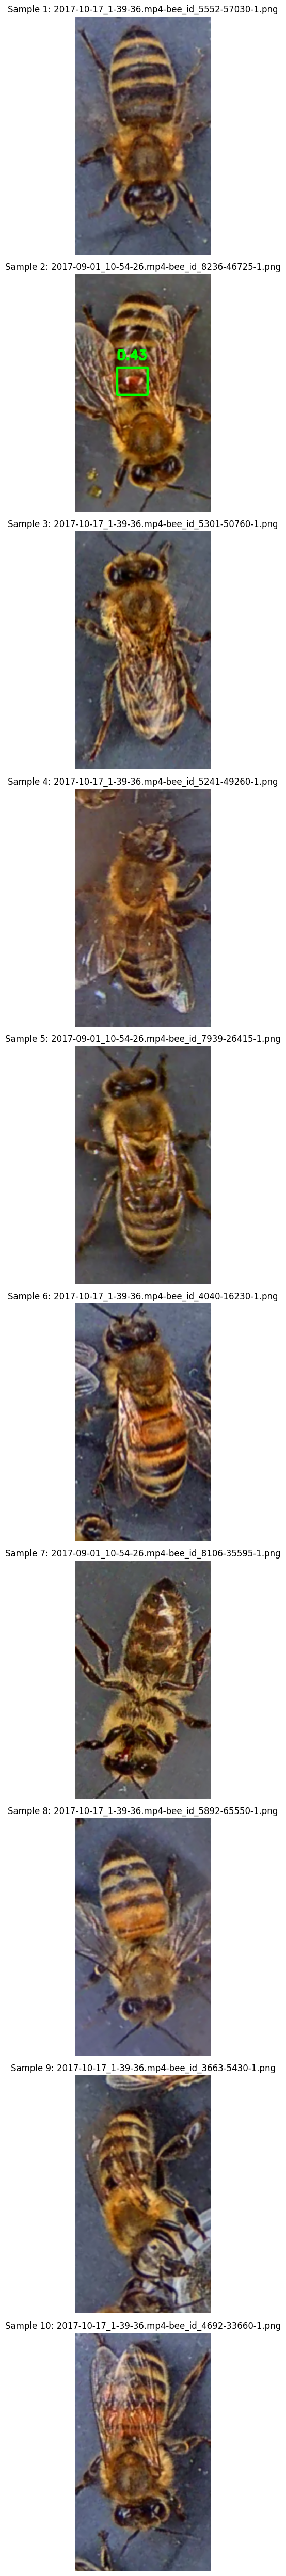

In [5]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_dir, num_samples=10):
    dataset_dicts = []
    for root, _, files in os.walk(os.path.join(data_dir, 'test', 'images')):
        for f in files:
            if f.endswith('.png'):
                dataset_dicts.append(os.path.join(root, f))
    plt.figure(figsize=(15, 5 * num_samples))
    for i, img_path in enumerate(np.random.choice(dataset_dicts, num_samples, replace=False)):
        img = cv2.imread(img_path)
        results = model(img_path, conf=0.25)[0]
        if len(results.boxes) > 2:
            scores = results.boxes.conf.cpu().numpy()
            top_scores_idx = np.argsort(scores)[-2:]
            boxes = results.boxes.xyxy.cpu().numpy()[top_scores_idx]
            scores = scores[top_scores_idx]
        else:
            boxes = results.boxes.xyxy.cpu().numpy()
            scores = results.boxes.conf.cpu().numpy()
        for box, score in zip(boxes, scores):
            x_min, y_min, x_max, y_max = map(int, box)
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(img, f'{score:.2f}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img[:, :, ::-1])
        plt.title(f"Sample {i+1}: {os.path.basename(img_path)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, output_dir, num_samples=10)


# B. Faster R-CNN (Detectron2)


# Cell 1: Cài đặt Detectron2 và các thư viện


In [6]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git' --quiet
!pip install tqdm opencv-python matplotlib pandas --quiet


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.8 MB/s eta 0:00:00


# Cell 2: Tiền xử lý dữ liệu và chuyển annotation sang COCO


In [7]:
import pandas as pd
import os
import json
from tqdm import tqdm

def read_gt_csv(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            image_path = parts[0]
            label = int(parts[1])
            if label == 3:
                label = 1
            bboxes = []
            if label == 1:
                num_bboxes = (len(parts) - 2) // 4
                for i in range(num_bboxes):
                    bbox = list(map(int, parts[2 + i*4: 6 + i*4]))
                    bboxes.append(bbox)
            data.append({
                'image_path': image_path,
                'label': label,
                'bboxes': bboxes
            })
    return pd.DataFrame(data)

def create_coco_format(df, split_name, image_dir):
    coco_data = {
        "info": {"description": f"Varroa Detection {split_name}"},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "varroa", "supercategory": "insect"}
        ]
    }
    annotation_id = 1
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        image_id = idx + 1
        relative_path = row['image_path'].replace('test/', '').replace('train/', '').replace('val/', '')
        image_path = os.path.join(image_dir, split_name, relative_path)
        coco_data['images'].append({
            "id": image_id,
            "file_name": os.path.join(split_name, relative_path),
            "width": 160,
            "height": 280
        })
        if row['label'] == 1:
            for bbox in row['bboxes']:
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min
                coco_data['annotations'].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 1,
                    "bbox": [x_min, y_min, width, height],
                    "area": width * height,
                    "iscrowd": 0
                })
                annotation_id += 1
    return coco_data

def process_data(gt_csv_path, output_dir, image_dir):
    df = read_gt_csv(gt_csv_path)
    df['split'] = df['image_path'].apply(lambda x: 'train' if 'train/' in x else 'val' if 'val/' in x else 'test')
    os.makedirs(output_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        split_df = df[df['split'] == split]
        coco_data = create_coco_format(split_df, split, image_dir)
        output_path = os.path.join(output_dir, f'{split}_coco.json')
        with open(output_path, 'w') as f:
            json.dump(coco_data, f, indent=2)
        print(f"Saved {split} data to {output_path}")

gt_csv_path = '/kaggle/input/varroadatasets/VarroaDataset/gt.csv'
output_dir = '/kaggle/working/coco_annotations'
image_dir = '/kaggle/input/varroadatasets/VarroaDataset'
process_data(gt_csv_path, output_dir, image_dir)


Processing train: 100%|██████████| 8225/8225 [00:00<00:00, 22936.65it/s]


Saved train data to /kaggle/working/coco_annotations/train_coco.json


Processing val: 100%|██████████| 1876/1876 [00:00<00:00, 21605.10it/s]


Saved val data to /kaggle/working/coco_annotations/val_coco.json


Processing test: 100%|██████████| 3408/3408 [00:00<00:00, 23049.34it/s]


Saved test data to /kaggle/working/coco_annotations/test_coco.json


# Cell 3: Training, Evaluation và Visualization với Detectron2


model_final_280758.pkl: 167MB [00:00, 248MB/s]                           
Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training Progress:   2%|▏         | 19/1000 [00:05<04:19,  3.79it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1751466532.568931      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751466532.619859      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Training Progress: 100%|██████████| 1000/

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.399
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0

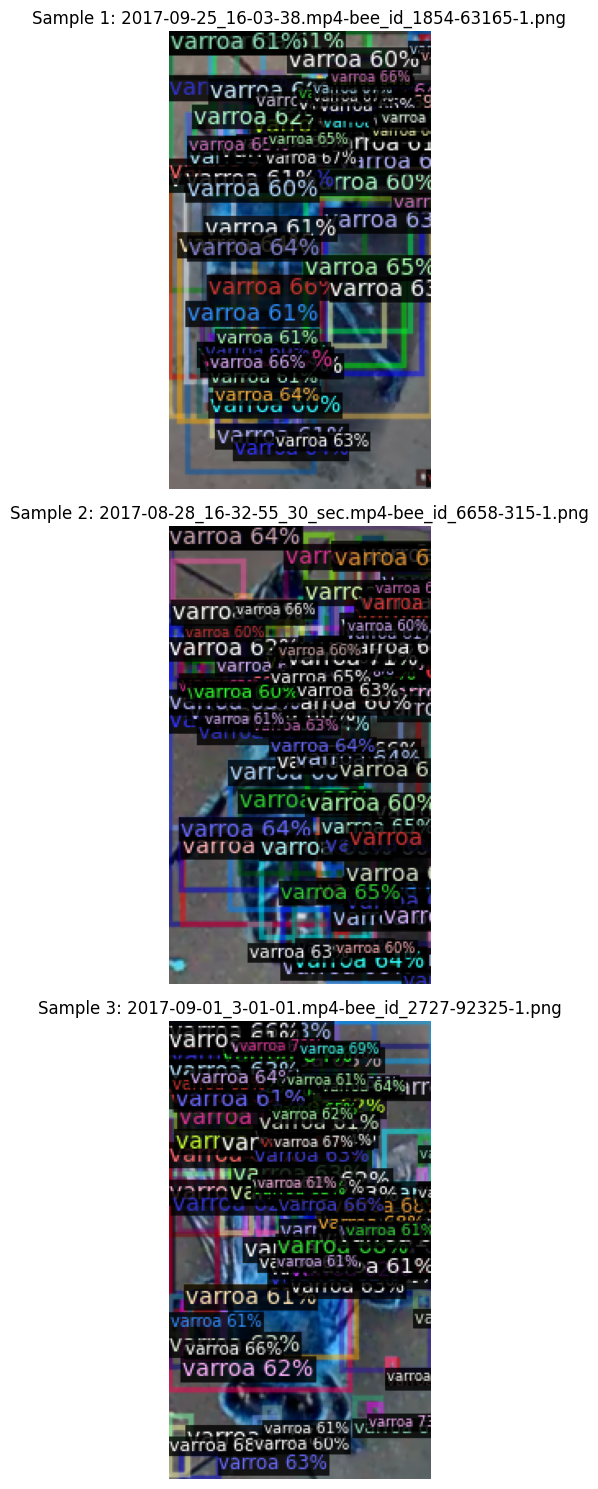

In [8]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, DatasetCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm

class ProgressHook(HookBase):
    def __init__(self, max_iter):
        self.max_iter = max_iter
        self.pbar = None
    def before_train(self):
        self.pbar = tqdm(total=self.max_iter, desc="Training Progress")
    def after_step(self):
        self.pbar.update(1)
    def after_train(self):
        self.pbar.close()

def visualize_predictions(cfg, num_samples=3):
    dataset_dicts = DatasetCatalog.get("varroa_val")
    metadata = MetadataCatalog.get("varroa_val")
    predictor = DefaultPredictor(cfg)
    plt.figure(figsize=(15, 5 * num_samples))
    for i, d in enumerate(np.random.choice(dataset_dicts, num_samples, replace=False)):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1], metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(v.get_image()[:, :, ::-1])
        plt.title(f"Sample {i+1}: {os.path.basename(d['file_name'])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def train_and_evaluate_faster_rcnn():
    register_coco_instances("varroa_train", {}, "/kaggle/working/coco_annotations/train_coco.json", "/kaggle/input/varroadatasets/VarroaDataset")
    register_coco_instances("varroa_val", {}, "/kaggle/working/coco_annotations/val_coco.json", "/kaggle/input/varroadatasets/VarroaDataset")
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("varroa_train",)
    cfg.DATASETS.TEST = ("varroa_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    trainer = DefaultTrainer(cfg)
    trainer.register_hooks([ProgressHook(cfg.SOLVER.MAX_ITER)])
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer.resume_or_load(resume=False)
    trainer.train()
    evaluator = COCOEvaluator("varroa_val", cfg, False, output_dir="/kaggle/working/eval_output/")
    val_loader = build_detection_test_loader(cfg, "varroa_val")
    eval_results = inference_on_dataset(trainer.model, val_loader, evaluator)
    print(eval_results)
    print("\nVisualizing sample object detection results...")
    visualize_predictions(cfg, num_samples=3)

train_and_evaluate_faster_rcnn()
